# Studying location of condensation points

In [61]:
import numpy as np
import torch

from gnn_tracking.metrics.cluster_metrics import tracking_metric_dfs
from gnn_tracking.postprocessing.clusterscanner import sort_according_to_mask
from gnn_tracking_hpo.trainable import PretrainedECTCNTrainable
plt.style.use('sss1.mplstyle')

## Load model

In [2]:
trainable = PretrainedECTCNTrainable.reinstate(
    "fixed-ec-50029d0b",
    "ba8a937f",
    epoch=-1,
    config_override=dict(n_graphs_train=1, n_graphs_val=300, n_graphs_test=1)
)

[12:53:55 HPO] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-50029d0b/PretrainedECTrainable_ba8a937f_10_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_wei_2023-05-04_18-10-52/params.json
[12:53:55 HPO] INFO: I'm running on a node with job ID=48042336
[12:53:55 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[12:53:55 HPO] INFO: The ID of my dispatcher is 0
[12:53:55 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[12:53:55 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1                    │ 0.9                                      │
│ adam_beta2                    │ 0.999                                 

## Default Evaluate

In [13]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
trainer: TCNTrainer = trainable.trainer
trainer.max_batches_for_clustering = 10000
results = trainer.test_step()

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: Type

In [18]:
results

{'total': 0.05048439947888255,
 'potential_attractive': 0.03251016446544478,
 'potential_attractive_weighted': 0.03251016446544478,
 'potential_repulsive': 0.1132416441415747,
 'potential_repulsive_weighted': 0.013895036713993498,
 'background': 0.9949264578024546,
 'background_weighted': 0.004079198476990064,
 'acc_pt0.9': 0.9988147970009843,
 'TPR_pt0.9': 0.9570946334817023,
 'TNR_pt0.9': 0.9995457198353802,
 'FPR_pt0.9': 0.00045428016461989686,
 'FNR_pt0.9': 0.04290536651829772,
 'balanced_acc_pt0.9': 0.9783201766585413,
 'F1_pt0.9': 0.9651805465801124,
 'MCC_pt0.9': 0.9646624775857666,
 'max_ba_pt0.9': 0.9920155101026724,
 'max_ba_loc_pt0.9': 0.2241541013121605,
 'max_f1_pt0.9': 0.9685963992886109,
 'max_f1_loc_pt0.9': 0.41504187206427257,
 'max_mcc_pt0.9': 0.9682505191424646,
 'max_mcc_loc_pt0.9': 0.41603014677762984,
 'tpr_eq_tnr_pt0.9': 0.9907822074002737,
 'tpr_eq_tnr_loc_pt0.9': 0.20405359894037248,
 'roc_auc_pt0.9': 0.9995687172810237,
 'roc_auc_0.001FPR_pt0.9': 0.97468614021

In [16]:
for k in sorted(results):
    print(k, results[k])

F1_pt0.9 0.9651805465801124
F1_pt0.9_std 0.014507453477321908
F1_pt1.5 0.9578892012699023
F1_pt1.5_std 0.028903394369083745
FNR_pt0.9 0.04290536651829772
FNR_pt0.9_std 0.02052619726380742
FNR_pt1.5 0.05030582645732644
FNR_pt1.5_std 0.038039447521994445
FPR_pt0.9 0.00045428016461989686
FPR_pt0.9_std 0.00019325651542694035
FPR_pt1.5 0.00048158162408544215
FPR_pt1.5_std 0.000347809423691882
MCC_pt0.9 0.9646624775857666
MCC_pt0.9_std 0.014573370966472087
MCC_pt1.5 0.9574783360523448
MCC_pt1.5_std 0.028943753547324425
TNR_pt0.9 0.9995457198353802
TNR_pt0.9_std 0.00019325651542693737
TNR_pt1.5 0.9995184183759146
TNR_pt1.5_std 0.0003478094236918819
TPR_pt0.9 0.9570946334817023
TPR_pt0.9_std 0.020526197263807423
TPR_pt1.5 0.9496941735426735
TPR_pt1.5_std 0.03803944752199444
acc_pt0.9 0.9988147970009843
acc_pt0.9_std 0.0003724234841355086
acc_pt1.5 0.9987919817954105
acc_pt1.5_std 0.0006694302970954857
adjusted_rand 0.014987223017495808
adjusted_rand_std 0.0043050262451097415
background 0.99492

In [9]:
0.91/0.83

1.0963855421686748

In [17]:
0.04/np.sqrt(300)

0.0023094010767585028

## Evaluate in detail

In [4]:
from gnn_tracking.metrics.cluster_metrics import count_tracking_metrics
import itertools


def get_h_df(data, model_output):
    m = model_output["ec_hit_mask"].cpu().numpy()

    def prep(x):
        return sort_according_to_mask([x.cpu().numpy()], [m])[0]

    return pd.DataFrame({
        "c": np.concatenate([clusters, np.full(data.x.shape[0] - clusters.shape[0], -1)]),
        "id": prep(data.particle_id),
        "reconstructable": prep(data.reconstructable),
        "pt": prep(data.pt),
        "eta": prep(data.x[:, 3]),
        # "phi": prep(data.x[:, 2]),
    })




In [50]:
from tqdm import tqdm
from gnn_tracking.postprocessing.dbscanscanner import dbscan
import torch
import pandas as pd

trainer = trainable.trainer
model = trainer.model
model.eval()
max_batches = 100
m_data = []
with torch.no_grad():
    for _batch_idx, data in enumerate(tqdm(trainer.val_loader)):
        if _batch_idx > max_batches:
            break
        model_output = trainer.evaluate_model(
            data,
            mask_pids_reco=False,
        )
        clusters = dbscan(model_output["x"], eps=0.99)
        h_df = get_h_df(data, model_output)
        c_df = tracking_metric_dfs(h_df)
        m_data.append((h_df, c_df))

  0%|                                                                                                          | 0/300 [00:00<?, ?it/s]/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_sha

In [51]:
c_df = tracking_metric_dfs(h_df)

In [86]:
def tracking_metrics_vs_pt(h_df, c_df, pts):
    for pt_min, pt_max in itertools.pairwise(pts):
        c_mask = (
            (c_df["maj_pt"] < pt_max) & (c_df["maj_pt"] >= pt_min) & c_df["maj_reconstructable"] & c_df["valid_cluster"]
        )
        h_mask = (h_df["pt"] < pt_max) & (h_df["pt"] >= pt_min) & h_df["reconstructable"].astype(bool)
        yield count_tracking_metrics(c_df, h_df, c_mask, h_mask)

def tracking_metrics_vs_var(h_df, c_df, vars, var="eta", pt_min=0.9):
    for var_min, var_max in itertools.pairwise(vars):
        c_mask = (
            (c_df["maj_pt"] >= pt_min) & (c_df[f"maj_{var}"] < var_max) & (c_df[f"maj_{var}"] >= var_min) & c_df["maj_reconstructable"] & c_df["valid_cluster"]
        )
        h_mask = (h_df["pt"] >= pt_min) & (h_df[var] < var_max) & (h_df[var] >= var_min) & h_df["reconstructable"].astype(bool)
        yield count_tracking_metrics(c_df, h_df, c_mask, h_mask)

In [111]:

pts = np.linspace(0, 2, 20)
etas = np.linspace(-4.2, 4.2, 20)
rs_pt = []
rs_eta = []
for h_df, c_df in m_data:
    rs_pt.extend(list(tracking_metrics_vs_pt(h_df, c_df, pts)))
    rs_eta.extend(list(tracking_metrics_vs_var(h_df, c_df, etas, "eta")))

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b


In [112]:
def aggregate(results, key, n_batches):
    assert len(results) % n_batches == 0
    n_bins = len(results) // n_batches
    return (
        [np.mean([r[key] for r in results[i::n_bins]]) for i in range(n_bins)],
        [np.std([r[key] for r in results[i::n_bins]]) / np.sqrt(n_batches) for i in range(n_bins)],
    )


In [113]:
from matplotlib import pyplot as plt

def plot_metrics(results, xs):
    n_batches = len(results) // (len(xs)-1)
    print(n_batches)
    y, ey = aggregate(results, "double_majority", n_batches)
    plt.stairs(y, edges=xs)
    plt.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C0")
    y, ey = aggregate(results, "lhc", n_batches)
    plt.stairs(y, edges=xs)
    plt.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C1")
    y, ey = aggregate(results, "perfect", n_batches)
    plt.stairs(y, edges=xs)
    plt.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C2")

101


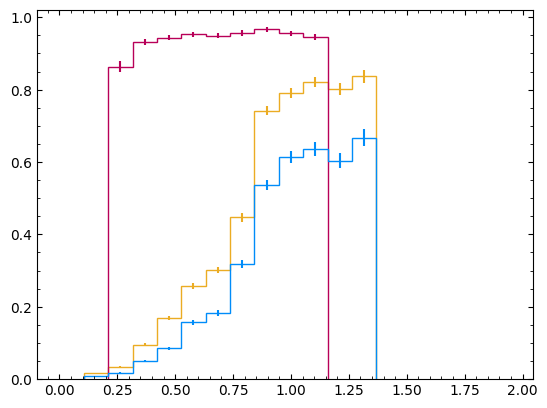

In [114]:
plot_metrics(list(rs_pt), pts)

101


StopIteration: 

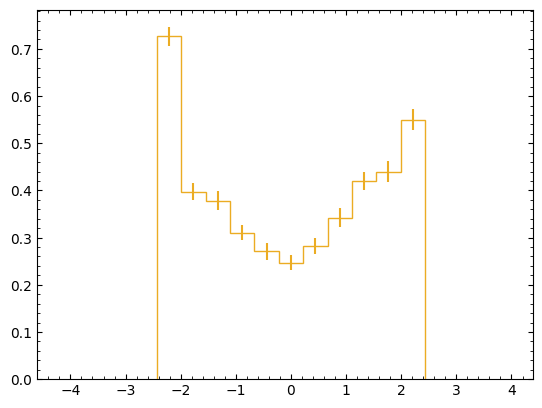

In [115]:
plot_metrics(rs_eta, etas)